# Databased analysis of conventional plants in Germany


### Introduction

This Jupyter-Notebook is a step for step handbook for calculating the emission factors of conventional plants powered by lignite, hard coal and gas in Germany.

Only plants, that are mandated to submit generation data are included. This refers to plants with a total nominal electrical power of least 200 MW or single blocks with a nominal elctrical power of at least 100 MW.


<b>Step 1</b>: Preparation of Python environment. The necessary modules (pandas, numpy, matplotlib, copy, itertools, scipy) and all dependencies need to be installed.<br>

<b>Step 2</b>: Download of input files and setup of folder structure

* List of conventional powerplants blocks.xlsx needs to be included in the input folder.
* Powerplant generation data needs to be downloaded from https://transparency.entsoe.eu/. Therefore, use any SFTP client and follow the instructions on https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/SFTP-Transparency_Docs.html to access the ento-e database. Open the folder 'ActualGenerationOutputPerGenerationUnit_16.1.A' and download all files for the relevant years. Include the files into the /input/entsoe folder.
* Emissions and allocations data needs to be downloaded from https://climate.ec.europa.eu/eu-action/eu-emissions-trading-system-eu-ets/union-registry_en#documentation. Access the link, go to section 'Phase IV (2021-2030)' - 'Reports' and download the file 'Verified Emissions for 2021'. Delete the informational rows marked in yellow. Include the file into the /input/EC folder.

In [1]:
# MODULE IMPORTS
import pandas as pd
import numpy as np

In [2]:
# SELECTION OF YEARS
# data is currently provided for the years of 2016 to 2021
years = [2016, 2017, 2018, 2019, 2020, 2021]

In [3]:
# FILE IMPORTS
# import main file for German powerplant data including EIC, ETS-ID, electrical and heat power, CHP
blocks = pd.read_excel('input/blocks.xlsx')

# import powerplant generation data (source: entso-e)
pp_gen_data = dict()
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
for y in years:
    pp_gen_data[y] = []
    for m in months:
        pp_gen_data[y].append(pd.read_csv("input/entsoe/" + str(y) + "_" + m + "_ActualGenerationOutputPerGenerationUnit_16.1.A.csv", header=0, delimiter='\t', parse_dates=True))

# import data on verified emissions and free emission allocations (source: EC)
EC_data = pd.read_excel('input/EC/verified_emissions_2021_en.xlsx')
EC_data = EC_data[EC_data.REGISTRY_CODE == 'DE']

In [4]:
# GENERAL DEFINITIONS

# list of all powerplant block EIC codes
eic_list = blocks['EIC'].unique()

# list of all powerplant location ETS-ID codes
ets_list = blocks['ETS-ID'].unique()

### Calculation of yearly generation

Generation data is provided by entso-e on an hourly basis. The hourly data is aggregated to the per-year level and adjusted for missing data points. The data is EIC-specific, and thus evaluated on the block level.

In [5]:
# CALCULATION OF YEARLY GENERATION PER BLOCK

gen = pd.DataFrame(eic_list, columns=['EIC'])
# create empty columns for yearly generation amounts and number of data points
for y in years:
    gen['Generation elec. ' + str(y) + ' [MWh_el]'] = 0
    gen['No. data points ' + str(y)] = 0

# calculate total generation per block per year and extract the number of data points
for y in years:
    gen_data_y = pp_gen_data[y]
    for m in range(12):
        gen_data_m = gen_data_y[m]
        for p in eic_list:
            # extract powerplant-specific hourly generation data (one month)
            gen_data_m_p = gen_data_m[gen_data_m['GenerationUnitEIC']==p]
            gen_m_p = gen_data_m_p.sum()['ActualGenerationOutput']
            # aggregate monthly generation data to per year level
            gen.loc[gen['EIC']==p,'Generation elec. ' + str(y) + ' [MWh_el]'] += gen_m_p

            # extract the number of hourly generation data points
            dp_m_p = len(gen_data_m_p.index)
            # aggregate monthly data points to per year level
            gen.loc[gen['EIC']==p, 'No. data points '+str(y)] += dp_m_p

# if generation is reported for every hour of the year, 8760 data points are available and no adjustemnts are needed
# in case that data is missing, the generation is scaled based on the number of data points available
for index, row in gen.iterrows():
    for y in years:
        if row['No. data points '+str(y)] != 0 & row['No. data points '+str(y)] != 8760:
            # calculate correction factor as 8760/number of data points
            corr_fac = 8760/row['No. data points '+str(y)]
            # adjust generation based on correction factor
            gen.loc[index,'Generation elec. '+str(y) + ' [MWh_el]'] = gen.loc[index,'Generation elec. '+str(y) + ' [MWh_el]'] * corr_fac

# add generation data to the main powerplant block DataFrame
for p in eic_list:
    for y in years:
        blocks.loc[blocks['EIC']==p, 'Generation elec. '+str(y)+' [MWh_el]'] = gen.loc[gen['EIC']==p, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        blocks.loc[blocks['EIC']==p, 'No. data points '+str(y)] = int(gen.loc[gen['EIC']==p, 'No. data points '+str(y)])

### Aggregation and accessing allocation/emission data

While generation data is provided on powerplant block level (EIC-specific), emission and allocation data is provided on powerplant installation level (ETS ID-specific). Thus, aggregation of multiple blocks within the same installation has to be done before accessing the ETS data.

In [6]:
# AGGREGATION TO PLANT LEVEL

# iterate through ETS-IDs and aggregate the data
installations = []
for id in ets_list:
    # extract raw data
    id_data_raw = blocks.loc[blocks['ETS-ID']==id]
    id_data = dict()
    id_data['ETS-ID'] = id
    id_data['City'] = id_data_raw['City'].iloc[0]
    id_data['Plant name'] = id_data_raw['Plant name'].iloc[0]
    # nominal heat and electricity power of the blocks get summed
    id_data['Net electrical power [MW_el]'] = id_data_raw['Net electrical power [MW_el]'].sum()
    id_data['Heat power [MW_th]'] = id_data_raw['Heat power [MW_th]'].sum()
    # if one block of the plant uses CHP, the whole plant is marked as CHP plant
    id_data['CHP'] = id_data_raw['CHP'].any()
    # differentiation between single and mixed fuel type plants
    fuels = id_data_raw['Fuel'].unique()
    fuel = fuels[0] if len(fuels)==1 else 'mixed'
    id_data['Fuel'] = fuel
    if fuel == 'mixed':
        id_data['Thermal fuel emission factor [t/MWh_th]'] = np.NaN
    else:
        id_data['Thermal fuel emission factor [t/MWh_th]'] = id_data_raw['Fuel emission factor [t/MWh_th]'].iloc[0]

    for y in years:
        # generation and calculated emissions of the blocks get summed
        gen_id_y = id_data_raw['Generation elec. ' + str(y) + ' [MWh_el]'].sum()
        id_data['Generation elec. ' + str(y) + ' [MWh_el]'] = gen_id_y
    
    installations.append(id_data)
installations = pd.DataFrame(installations)

In [7]:
# ACCESSING VERIFIED EMISSION AND ALLOCATION DATA

# iterate through ETS-IDs to access verified emissions and free allocations
for y in years:
    for id in ets_list:
        row = EC_data.loc[EC_data['INSTALLATION_IDENTIFIER']==id]
        if row.empty:
            allocation = None
            emissions = None
        else:
            # access allocation and emission data
            allocation = row['ALLOCATION_'+str(y)].values[0]
            emissions = row['VERIFIED_EMISSIONS_'+str(y)].values[0]
            # access generation data for reference
            generation = installations.loc[installations['ETS-ID']==id, 'Generation elec. ' + str(y) + ' [MWh_el]'].values[0]

            # processing of missing entries (-1)
            # if generation is zero, the missing values are caused by the plant not being operational, thus missing are set to zero
            if emissions==-1 and generation==0:
                    emissions = 0
            if allocation==-1 and generation==0:
                    allocation = 0

        installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'] = allocation
        installations.loc[installations['ETS-ID']==id, 'Emissions '+str(y)+' [t]'] = emissions
    
# processing of missing entries (-1)
# if only one missing entry per installation is found, this is most likely caused by the plant being practically no longer operational with generation close to zero
# in these cases, missing allocation data is set to zero
for id in ets_list:
    count_missing = 0
    for y in years:
        if installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0] == -1:
            count_missing +=1
    if count_missing == 1:
        for y in years:
            if installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0] == -1:
                installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'] = 0

# use NaN for missing values instead of -1 for calculation purposes
installations.replace(-1, np.NaN, inplace=True)

### Seperation of electricity and heat related emissions

Based on the regulation of the EU European Trading Scheme, electricity and heat emissions can be seperated. Linear reduction factor and carbon leakage exposure factor are calculated. In combination with the ETS verified emissions, the share of carbon leakage related emissions "sigma" is be calculated.

In [8]:
# CALCULATION OF SIGMA
# define combinations of consecutive years
years_cons = [[y, y+1] for y in years][:-1]

for id in ets_list:
    sigma = np.NaN
    sigma_list = dict()
    # calculation of sigma for each powerplant and set of consecutive years
    for y in years_cons:
        # 2013 is defined as the base year in the EU ETS regulations
        k_0 = y[0] - 2013
        k_1 = y[1] - 2013
        # calculation of linear reduction factors
        lrf_0 = 1 - 0.0174*k_0 if y[0]<=2020 else 0.8782 - 0.022*k_0
        lrf_1 = 1 - 0.0174*k_1 if y[1]<=2020 else 0.8782 - 0.022*k_1
        # calculation of carbon leakage exposure factors
        clef_0 = 0.8 - (0.5/7)*k_0
        clef_1 = 0.8 - (0.5/7)*k_1
        # extraction of emission allocations
        alloc_0 =  installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y[0])+' [t]'].values[0]
        alloc_1 =  installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y[1])+' [t]'].values[0]
        # calculation of sigma
        if alloc_0 == 0 and alloc_1 == 0:
            sigma_y = 0
        else:
            sigma_y = (alloc_0*lrf_1*clef_1 - alloc_1*lrf_0*clef_0)/(alloc_1*lrf_0*(1-clef_0) - alloc_0*lrf_1*(1-clef_1))
        sigma_list[str(y)] = sigma_y
        
    # special case for zero heat emissions over all years
    if all(sigma_y == 0 for sigma_y in sigma_list.values()):
        sigma = 0
        installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma
        continue

    # zeros are removed since they typically occur when the plant is not operational
    sigma_list = {y:sigma_y for y,sigma_y in sigma_list.items() if sigma_y!=0}

    # iterate through consecutive sigma values and identify occasions with a small deviation
    success = False
    for y_1, sigma_1 in sorted(list(sigma_list.items()), key=lambda x:x[0].lower(), reverse=True):
        # define years and sigmas for consecutive values
        y_1_list = str.split(y_1[1:-1], sep=',')
        y_1_list = [int(x.strip(' ')) for x in y_1_list]
        y_0_list = [x-1 for x in y_1_list]
        if str(y_0_list) in sigma_list.keys():
            sigma_0 = sigma_list[str(y_0_list)]
        else:
            continue
        
        # conditions: max. 10% relative difference or max. 0.01 absolute difference
        if abs(1-(sigma_1/sigma_0)) <= 0.1 or abs(sigma_1-sigma_0) <= 0.01:
            # calculation of the average sigma
            sigma_avg = (sigma_0+sigma_1)/2

            # only allow realistic values between 0 and 1
            if sigma_avg >= 0 and sigma_avg <= 1:
                sigma = sigma_avg
                success = True
            
            # round values slightly below 0 to 0 and values slightly above 1 to 1
            elif sigma_avg < 0 and sigma_avg >= -0.1:
                sigma = 0
                success = True
            elif sigma_avg > 1 and sigma_avg <= 1.1:
                sigma = 1
                success = True

        if success:
            installations.loc[installations['ETS-ID']==id, 'Sigma year'] = y_0_list[1]
            installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma
            break
    
    installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma

In [9]:
# CALCULATION OF ANNUAL HEAT GENERATION AND HEAT/ELECTRICITY-RELATED EMISSIONS

# definition of heat benchmark
hb = 0.22428 # in t/MWh_th, original value 62,3 t/TJ

# iterate through years and powerplant locations to calculate the heat generation from the allocation data
for id in ets_list:
    for y in years:
        # preparation of linear reduction factor, carbon leakage exposure factor, emission allocations and sigma
        k = y - 2013
        lrf = 1 - 0.0174*k if y<=2020 else 0.8782 - 0.022*k
        clef = 0.8 - (0.5/7)*k
        alloc = installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0]
        sigma = installations.loc[installations['ETS-ID']==id, 'Sigma'].values[0]

        # calculation of annual heat generation
        gen_heat = alloc / (hb * lrf * (sigma + (1 - sigma) * clef))

        # calculation of annual heat-related emissions
        em_heat = gen_heat * hb

        # calculation of annual electricity-related emissions
        em_total = installations.loc[installations['ETS-ID']==id, 'Emissions '+str(y)+' [t]'].values[0]
        em_elec = em_total - em_heat

        installations.loc[installations['ETS-ID']==id, 'Generation heat ' + str(y) + ' [MWh_th]'] = gen_heat
        installations.loc[installations['ETS-ID']==id, 'Emissions (heat) ' + str(y) + ' [t]'] = em_heat
        installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) ' + str(y) + ' [t]'] = em_elec

### Calculation of emissions factors

The yearly installation-specific emission factor is calculated using electricity-related emissions and generation data.

In [10]:
# CALCULATION OF EMISSION FACTOR

# iterate through years and installations to calculate the emission factors
for id in ets_list:
    em_fac_list = []
    for y in years:
        # access generation and emission data
        gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) '+str(y)+' [t]'].values[0]

        # calculation of emission factor
        if em_elec == 0 or gen == 0:
            em_fac = np.NaN
        else:
            em_fac = em_elec / gen
        em_fac_list.append(em_fac)
        installations.loc[installations['ETS-ID']==id, 'Emission factor ' + str(y) + ' [t/MWh_el]'] = em_fac

    # remove nan entries and unrealistically low/high values
    em_fac_list = [x for x in em_fac_list if str(x) != 'nan']
    em_fac_list = [x for x in em_fac_list if x<5 and x>-0.1]
    # calculate average emission factor
    if em_fac_list:
        em_fac_avg = sum(em_fac_list) / len(em_fac_list)
    else:
        em_fac_avg = np.NaN
    installations.loc[installations['ETS-ID']==id, 'Emission factor avg. [t/MWh_el]'] = em_fac_avg

### Analysis and plotting of emission factor data

In [11]:
# DATA PREPARATION
# define unique fuel types
fuel_types = list(installations['Fuel'].unique())
fuel_types.remove('mixed')

# create long format DataFrame containing ETS-ID, Fuel Type, Year, Emission factors
em_data_raw = installations[installations['Emission factor avg. [t/MWh_el]'].notna()]
em_data = []
for id in em_data_raw['ETS-ID'].unique():
    for y in years:
        em_data_y = []
        em_data_y.append(id)
        em_data_y.append(y)
        em_data_y.append(em_data_raw.loc[em_data_raw['ETS-ID']==id, 'Fuel'].values[0])
        em_data_y.append(em_data_raw.loc[em_data_raw['ETS-ID']==id, 'Emission factor '+str(y)+' [t/MWh_el]'].values[0])
        em_data.append(em_data_y)
em_data = pd.DataFrame(em_data, columns=['ETSID', 'Year', 'Fuel', 'Emission factor [t/MWh_el]'])
em_data = em_data[em_data['Emission factor [t/MWh_el]'].notna()]


In [12]:
# CALCULATION OF AVERAGE EMISSION FACTOR PER FUEL TYPE

em_fac_avg = dict()
for f in fuel_types:
    total_gen = 0
    total_em_elec = 0
    for id in ets_list:
        # filter by fuel type
        if installations.loc[installations['ETS-ID']==id]['Fuel'].values[0] == f:
            for y in years:
                # access generation and emission data
                gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
                em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) '+str(y)+' [t]'].values[0]
                # add values to fuel type-specific sum
                if str(gen)!='nan' and str(em_elec)!='nan':
                    total_gen += gen
                    total_em_elec += em_elec
                    
    # calculate average emission factor
    if total_gen > 0:
        em_fac_avg[f] = total_em_elec / total_gen
    else:
        em_fac_avg[f] = np.NaN
    
# Output: Average emission factor for each fuel type
print("Average emission factors per fuel type:")
for f in fuel_types:
    print(f + ": " + str(round(em_fac_avg[f],2)) + " t/MWh_el")

Average emission factors per fuel type:
crude oil: 1.06 t/MWh_el
NG: 0.36 t/MWh_el
hard coal: 0.93 t/MWh_el
BFG: 2.68 t/MWh_el
lignite: 1.01 t/MWh_el
heavy fuel oil: 1.09 t/MWh_el
light fuel oil: nan t/MWh_el


In [13]:
# IMPORTS FOR PLOTTING
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale = 1.25)
rcParams['figure.figsize'] = 15,8

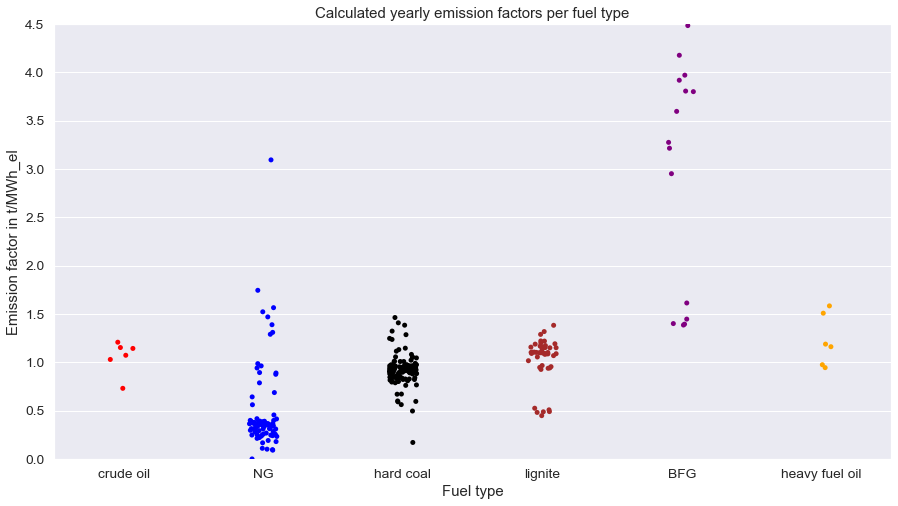

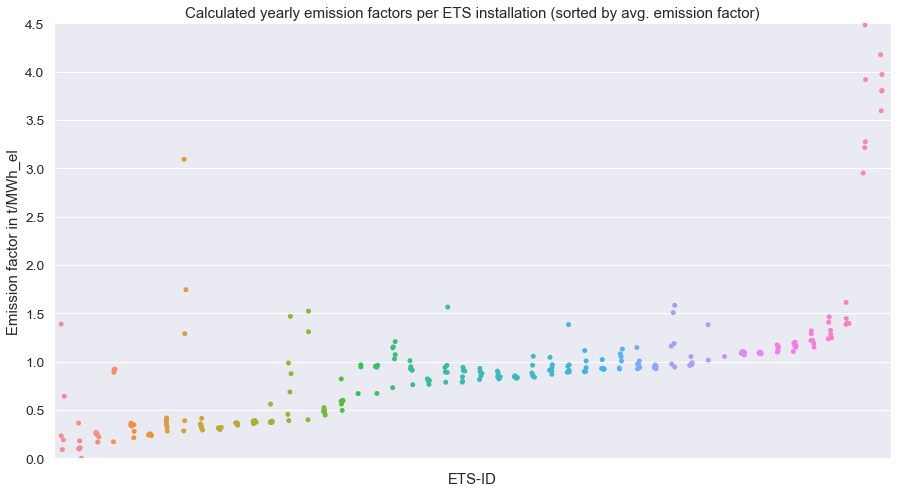

In [20]:
# PLOTTING OF EMISSION FACTORS

# for plotting purposes, mixed fuel type plants are exluded
em_data_plot = em_data.loc[em_data['Fuel']!='mixed']
# color palette for fuel types
colors_ft = {'crude oil': 'red', 'NG': 'blue', 'hard coal': 'black', 'BFG': 'purple', 'lignite': 'brown', 'heavy fuel oil': 'orange', 'light fuel oil': 'green'}

# yearly emission factors grouped by fuel type
em_plot = sns.stripplot(data=em_data_plot, x='Fuel', y='Emission factor [t/MWh_el]', palette=colors_ft)
em_plot.set(title="Calculated yearly emission factors per fuel type", ylim=(0, 4.5), xlabel='Fuel type', ylabel='Emission factor in t/MWh_el')
plt.savefig('output/plots/emission_factor-fuel_type.png')
plt.show()

# yearly emission factors grouped by individual installations
em_plot = sns.stripplot(data=em_data_plot, x='ETSID', y='Emission factor [t/MWh_el]', order=em_data_plot.sort_values('Emission factor [t/MWh_el]').ETSID.unique())
em_plot.set(title="Calculated yearly emission factors per ETS installation (sorted by avg. emission factor)", ylim=(0, 4.5), xticklabels=[], xlabel='ETS-ID', ylabel='Emission factor in t/MWh_el')
plt.savefig('output/plots/emission_factor-ETSID.png')
plt.show()

### Calculation of utilization ratio

The "Umweltbundesamt" provides thermal, fuel-specific/fuel-mix specific emission factors. In combination with the installation-specifc emission factors calculated above, the utilization ratio of each installation can be calculated.
<br><br>
Overview of emission factors (in t CO2 / MWh):
* Natural gas (NG): 0.2010
* Hard coal: 0.3368
* Lignite: Different values for the German mining areas of "Rheinland", "Lausitz", "Mitteldeutschland" and "Helmstedt"
* Oil: Different values for crude oil, light fuel oil and heavy fuel oil
* Blast furnace gas (BFG): 0.9319

<br>
Full source: Juhrich, K. & Umweltbundesamt, Fachgebiet Emissionssituation. (2009, June). CO2-Emissionsfaktoren für fossile Brennstoffe - Aktualisierung 2022. Climate Change, 28/2022, Article ISSN 1862-4359. https://www.umweltbundesamt.de/publikationen/co2-emissionsfaktoren-fuer-fossile-brennstoffe-0

In [17]:
# CALCULATION OF UTILIZATION FACTOR

# iterate through years and locations to calculate the utilization factors
for id in ets_list:
    utilization_list = []
    for y in years:
        # get emission factor data
        em_fac = installations.loc[installations['ETS-ID']==id, 'Emission factor '+str(y)+' [t/MWh_el]'].values[0]
        fuel_fac_th = installations.loc[installations['ETS-ID']==id, 'Thermal fuel emission factor [t/MWh_th]'].values[0]
        
        # calculation of utilization factor
        utilization = fuel_fac_th / em_fac
        utilization_list.append(utilization)
        installations.loc[installations['ETS-ID']==id, 'Utilization ratio ' + str(y) + ' [MWh_el/MWh_th]'] = utilization

    # remove nan entries and unrealistically low/high values
    utilization_list = [x for x in utilization_list if str(x) != 'nan']
    utilization_list = [x for x in utilization_list if x>=0 and x<=1]
    # calculate average utilization_factor
    if utilization_list:
        utilization_avg = sum(utilization_list) / len(utilization_list)
    else:
        utilization_avg = np.NaN
    installations.loc[installations['ETS-ID']==id, 'Utilization ratio avg. [MWh_el/MWh_th]'] = utilization_avg

### Analysis and plotting of utilization rate data

In [18]:
# DATA PREPARATION

# create long format DataFrame containing ETS-ID, Fuel Type, Year, Utilization rate
ut_data_raw = installations[installations['Utilization ratio avg. [MWh_el/MWh_th]'].notna()]
ut_data = []
for id in ut_data_raw['ETS-ID'].unique():
    for y in years:
        
        ut_data_y = []
        ut_data_y.append(id)
        ut_data_y.append(y)
        ut_data_y.append(ut_data_raw.loc[ut_data_raw['ETS-ID']==id, 'Fuel'].values[0])
        ut_data_y.append(ut_data_raw.loc[ut_data_raw['ETS-ID']==id, 'Utilization ratio '+str(y)+' [MWh_el/MWh_th]'].values[0])
        ut_data.append(ut_data_y)
ut_data = pd.DataFrame(ut_data, columns=['ETSID', 'Year', 'Fuel', 'Utilization ratio [MWh_el/MWh_th]'])
ut_data = ut_data[ut_data['Utilization ratio [MWh_el/MWh_th]'].notna()]

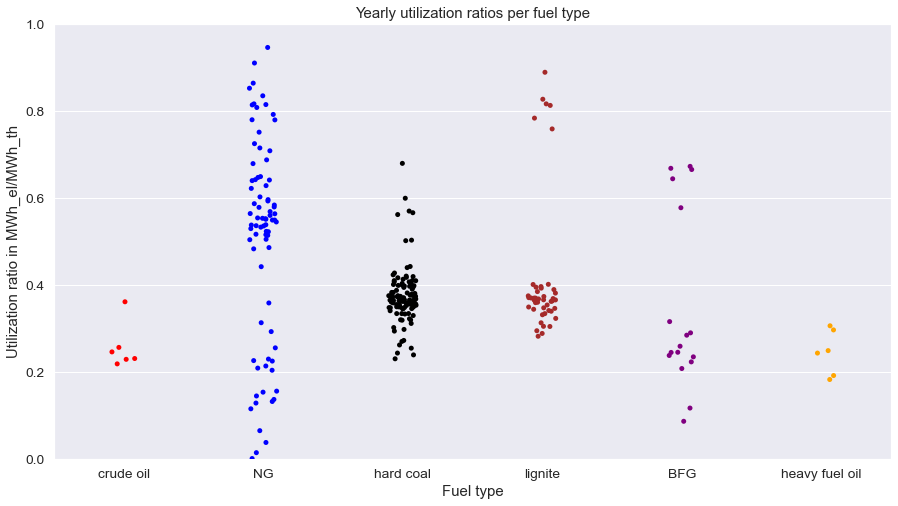

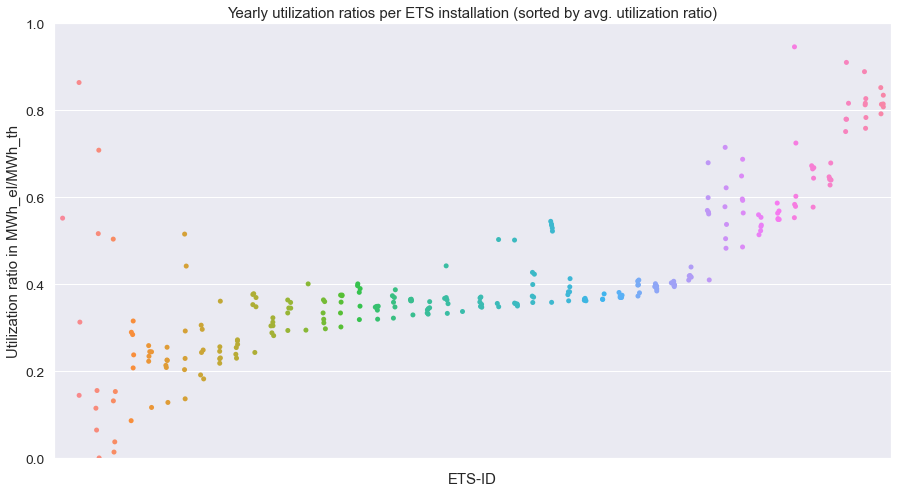

In [19]:
# PLOTTING OF UTILIZATION FACTORS

# yearly utilization factors grouped by fuel type
ut_plot = sns.stripplot(data=ut_data, x='Fuel', y='Utilization ratio [MWh_el/MWh_th]', palette=colors_ft)
ut_plot.set(title="Yearly utilization ratios per fuel type", ylim=(0, 1), xlabel='Fuel type', ylabel='Utilization ratio in MWh_el/MWh_th')
plt.savefig('output/plots/utilization_ratio-fuel_type.png')
plt.show()

# yearly emission factors grouped by individual installations
ut_plot = sns.stripplot(data=ut_data, x='ETSID', y='Utilization ratio [MWh_el/MWh_th]', order=ut_data.sort_values('Utilization ratio [MWh_el/MWh_th]').ETSID.unique())
ut_plot.set(title="Yearly utilization ratios per ETS installation (sorted by avg. utilization ratio)", ylim=(0, 1), xticklabels=[], xlabel='ETS-ID', ylabel='Utilization ratio in MWh_el/MWh_th')
plt.savefig('output/plots/utilization_ratio-ETSID.png')
plt.show()

### Output

Additionally to the block-wise input file, three output files are generated:
* Block-wise (long format): Yearly generation
* Installation-wise (wide format): Plant information overview containing fuel type, sigma, heat share, avg. emission factor
* Installation-wise (long format): Detailed yearly values including heat/electricity generation, emissions, emission factor, ...

In [21]:
# PREPARE BLOCK-WISE LONG FORMAT (GENERATION DATA)

out_block = []
for eic in eic_list:
    for y in years:
        # access generation information
        gen = blocks.loc[blocks['EIC']==eic, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        bna = blocks.loc[blocks['EIC']==eic, 'BNA-ID'].values[0]
        bna_name = blocks.loc[blocks['EIC']==eic, 'Name BNA'].values[0]
        plant_name = blocks.loc[blocks['EIC']==eic, 'Plant name'].values[0]
        block_name = str(blocks.loc[blocks['EIC']==eic, 'Block name'].values[0]) if str(blocks.loc[blocks['EIC']==eic, 'Block name'].values[0])!='nan' else ""
        name = plant_name + " " + block_name
        # store information
        out_block.append([eic, bna, bna_name, name, y, gen])
# convert to DataFrame
out_block = pd.DataFrame(out_block, columns=['EIC', 'BNA-ID', 'Name BNA', 'Plant & Block name', 'Year', 'Generation elec. [MWh_el]'])

In [22]:
# PREPARE INSTALLATION-WISE WIDE FORMAT
# note: sigma, heat share, and emission factor are stored for the year, for which sigma was calculated
#############################################################################################################
# WORK IN PROGRESS

out_installation_wide = []
for id in ets_list:
    # access information
    ft = installations.loc[installations['ETS-ID']==id, 'Fuel'].values[0]
    sigma = installations.loc[installations['ETS-ID']==id, 'Sigma'].values[0]
    sigma_year = installations.loc[installations['ETS-ID']==id, 'Sigma year'].values[0]
    if str(sigma_year) != 'nan':
        sigma_year = int(sigma_year)
        em_fac = installations.loc[installations['ETS-ID']==id, 'Emission factor ' + str(sigma_year) + ' [t/MWh_el]'].values[0]
        gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. ' + str(sigma_year) + ' [MWh_el]'].values[0]
        heat_gen = installations.loc[installations['ETS-ID']==id, 'Generation heat ' + str(sigma_year) + ' [MWh_th]'].values[0]
        # calculation of heat generation share
        heat_share = heat_gen / gen
    else:
        em_fac = np.NaN
        heat_share = np.NaN
    
    # store information
    out_installation_wide.append([id, ft, sigma, heat_share, em_fac])
# convert to DataFrame
out_installation_wide = pd.DataFrame(out_installation_wide, columns=['ETS-ID', 'Fuel type', 'Sigma', 'Heat share', 'Emission factor'])
#############################################################################################################

/var/folders/b8/z9v18hmn4x58qcsgkfvfd24h0000gn/T/ipykernel_28986/77071888.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  heat_share = heat_gen / gen


In [23]:
# PREPARE INSTALLATION-WISE LONG FORMAT
out_installation_long = []
for id in ets_list:
    for y in years:
        # access information
        gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. ' + str(y) + ' [MWh_el]'].values[0]
        em = installations.loc[installations['ETS-ID']==id, 'Emissions ' + str(y) + ' [t]'].values[0]
        em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) ' + str(y) + ' [t]'].values[0]
        em_heat = installations.loc[installations['ETS-ID']==id, 'Emissions (heat) ' + str(y) + ' [t]'].values[0]
        em_fac = installations.loc[installations['ETS-ID']==id, 'Emission factor ' + str(y) + ' [t/MWh_el]'].values[0]
        ut_fac = installations.loc[installations['ETS-ID']==id, 'Utilization ratio ' + str(y) + ' [MWh_el/MWh_th]'].values[0]
        
        # store information
        out_installation_long.append([id, y, gen, em, em_elec, em_heat, em_fac, ut_fac])

# convert to DataFrame
out_installation_long = pd.DataFrame(out_installation_long, columns=['ETS-ID', 'Year', 'Generation elec. [MWh_el]', 'Emissions [MWh]', 'Emissions (electricity) [MWh_el]', 'Emissions (heat) [MWh_th]', 'Emission factor [t/MWh_el]', 'Utilization ratio [MWh_el/MWh_th]'])

In [24]:
# EXPORT OUTPUT DATA
out_block.to_excel('output/block-generation.xlsx', sheet_name='Generation data', float_format="%.3f", index=False)
out_installation_wide.to_excel('output/installation-results.xlsx', sheet_name='Installation results', float_format="%.3f", index=False)
out_installation_long.to_excel('output/installation-results-yearly.xlsx', sheet_name='Yearly results', float_format="%.3f", index=False)

### Comparison of utilization rates to KIT data

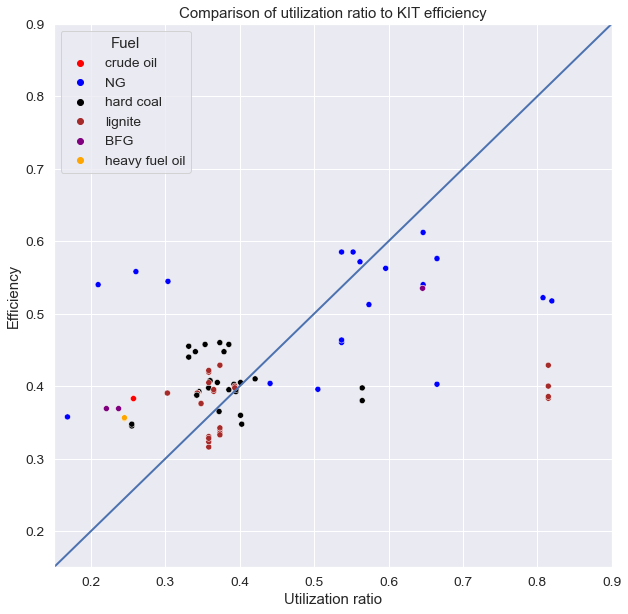

In [25]:
# assign utilization ratio to EIC for the values calculated above
ut_eic = []
for id in eic_list:
    ets = blocks.loc[blocks['EIC']==id, 'ETS-ID'].values[0]
    fuel = blocks.loc[blocks['EIC']==id, 'Fuel'].values[0]
    ut_eic.append([id, fuel, installations.loc[installations['ETS-ID']==ets, 'Utilization ratio avg. [MWh_el/MWh_th]'].values[0]])
ut_eic = pd.DataFrame(ut_eic, columns=['EIC', 'Fuel', 'Utilization ratio'])
ut_eic = ut_eic[ut_eic['Utilization ratio'].notna()]

# import and preparation of KIT data
data_kit = pd.read_csv('input/KIT/kraftwerke_wirkungsgrad.csv')
data_kit = data_kit.drop(columns=['PowerSystemResourceName', 'Fuel', 'Fuel_specification', 'bnetza_id', 'name_bnetza'])
data_kit.rename(columns={'GenerationUnitEIC': 'EIC'}, inplace=True)

# merge the two data sets
comp = pd.merge(ut_eic, data_kit, how='inner')

# graphical representatation
rcParams['figure.figsize'] = 10, 10
comp_plot = sns.scatterplot(data=comp, x='Utilization ratio', y='Efficiency', hue='Fuel', palette=colors_ft)
comp_plot.set(title="Comparison of utilization ratio to KIT efficiency", xlim=(0.15,0.9), ylim=(0.15, 0.9), xlabel='Utilization ratio', ylabel='Efficiency')
plt.plot([0, 1], [0, 1], linewidth=2)
plt.savefig('output/plots/KIT_efficiency-utilization_ratio.png')
plt.show()


### Evaluation of heat extraction for non-EIC powerplants

The data set is extended to all ETS-registered installations with the main acticity "combustion of fuels". This list of installations is not matched to EIC, to allow for the consideration of smaller plants. For this extended data set, the methodology from above is used with small adjustments to calculate Sigma, heat- and electricity related emissions, and heat generation for each plant.

In [29]:
# EVALUATION OF HEAT EXTRACTION FOR NON-EIC PLANTS

# extraction of all German powerplant EUETS identifiers with Activity=20 (combustion of fuels)
EC_data_all = EC_data[EC_data.MAIN_ACTIVITY_TYPE_CODE == 20]
ets_list_all = EC_data_all['INSTALLATION_IDENTIFIER'].unique()

# dataframe preparation
installations_all = []
for i in ets_list_all:
    etsid = i
    name = EC_data_all.loc[EC_data['INSTALLATION_IDENTIFIER']==i, 'INSTALLATION_NAME']
    installations_all.append([etsid, name])
installations_all = pd.DataFrame(installations_all, columns=['ETS-ID', 'Name ETS'])

# accessing of emission and allocation data
for y in years:
    for id in ets_list_all:
        row = EC_data_all.loc[EC_data_all['INSTALLATION_IDENTIFIER']==id]
        # access allocation and emission data
        allocation = row['ALLOCATION_'+str(y)].values[0]
        emissions = row['VERIFIED_EMISSIONS_'+str(y)].values[0]
        # processing of missing/unusual values
        if emissions == 'Excluded':
            emissions = np.NaN
        if emissions == -1:
            emissions = np.NaN
        if allocation == -1:
            allocation = np.NaN
        # store information in dataframe
        installations_all.loc[installations_all['ETS-ID']==id, 'Allocation '+str(y)+' [t]'] = allocation
        installations_all.loc[installations_all['ETS-ID']==id, 'Emissions '+str(y)+' [t]'] = emissions
installations_all.fillna(np.nan, inplace=True)

# calculation of sigma
for id in ets_list_all:
    sigma = np.NaN
    sigma_list = dict()
    # calculation of sigma for each powerplant and set of consecutive years
    for y in years_cons:
        # 2013 is defined as the base year in the EU ETS regulations
        k_0 = y[0] - 2013
        k_1 = y[1] - 2013
        # calculation of linear reduction factors
        lrf_0 = 1 - 0.0174*k_0 if y[0]<=2020 else 0.8782 - 0.022*k_0
        lrf_1 = 1 - 0.0174*k_1 if y[1]<=2020 else 0.8782 - 0.022*k_1
        # calculation of carbon leakage exposure factors
        clef_0 = 0.8 - (0.5/7)*k_0
        clef_1 = 0.8 - (0.5/7)*k_1
        # extraction of emission allocations
        alloc_0 =  installations_all.loc[installations_all['ETS-ID']==id, 'Allocation '+str(y[0])+' [t]'].values[0]
        alloc_1 =  installations_all.loc[installations_all['ETS-ID']==id, 'Allocation '+str(y[1])+' [t]'].values[0]
        # calculation of sigma
        if alloc_0 == 0 and alloc_1 == 0:
            sigma_y = 0
        else:
            sigma_y = (alloc_0*lrf_1*clef_1 - alloc_1*lrf_0*clef_0)/(alloc_1*lrf_0*(1-clef_0) - alloc_0*lrf_1*(1-clef_1))
        sigma_list[str(y)] = sigma_y
    # special case for zero heat emissions over all years
    if all(sigma_y == 0 for sigma_y in sigma_list.values()):
        sigma = 0
        installations_all.loc[installations['ETS-ID']==id, 'Sigma'] = sigma
        continue
    # zeros are removed since they typically occur when the plant is not operational
    sigma_list = {y:sigma_y for y,sigma_y in sigma_list.items() if sigma_y!=0}
    # iterate through consecutive sigma values and identify occasions with a small deviation
    success = False
    for y_1, sigma_1 in sorted(list(sigma_list.items()), key=lambda x:x[0].lower(), reverse=True):
        # define years and sigmas for consecutive values
        y_1_list = str.split(y_1[1:-1], sep=',')
        y_1_list = [int(x.strip(' ')) for x in y_1_list]
        y_0_list = [x-1 for x in y_1_list]
        if str(y_0_list) in sigma_list.keys():
            sigma_0 = sigma_list[str(y_0_list)]
        else:
            continue
        # conditions: max. 10% relative difference or max. 0.01 absolute difference
        if abs(1-(sigma_1/sigma_0)) <= 0.1 or abs(sigma_1-sigma_0) <= 0.01:
            # calculation of the average sigma
            sigma_avg = (sigma_0+sigma_1)/2
            # only allow realistic values between 0 and 1
            if sigma_avg >= 0 and sigma_avg <= 1:
                sigma = sigma_avg
                success = True
            # round values slightly below 0 to 0 and values slightly above 1 to 1
            elif sigma_avg < 0 and sigma_avg >= -0.1:
                sigma = 0
                success = True
            elif sigma_avg > 1 and sigma_avg <= 1.1:
                sigma = 1
                success = True
        if success:
            installations_all.loc[installations_all['ETS-ID']==id, 'Sigma year'] = y_0_list[1]
            installations_all.loc[installations_all['ETS-ID']==id, 'Sigma'] = sigma
            break
    installations_all.loc[installations_all['ETS-ID']==id, 'Sigma'] = sigma

# calculation of annual heat generation and heat/electricity-related emissions
for id in ets_list_all:
    for y in years:
        # preparation of linear reduction factor, carbon leakage exposure factor, emission allocations and sigma
        k = y - 2013
        lrf = 1 - 0.0174*k if y<=2020 else 0.8782 - 0.022*k
        clef = 0.8 - (0.5/7)*k
        alloc = installations_all.loc[installations_all['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0]
        sigma = installations_all.loc[installations_all['ETS-ID']==id, 'Sigma'].values[0]
        # calculation of annual heat generation
        gen_heat = alloc / (hb * lrf * (sigma + (1 - sigma) * clef))
        # calculation of annual heat-related emissions
        em_heat = gen_heat * hb
        # calculation of annual electricity-related emissions
        em_total = installations_all.loc[installations_all['ETS-ID']==id, 'Emissions '+str(y)+' [t]'].values[0]
        em_elec = em_total - em_heat
        # store information
        installations_all.loc[installations_all['ETS-ID']==id, 'Generation heat ' + str(y) + ' [MWh_th]'] = gen_heat
        installations_all.loc[installations_all['ETS-ID']==id, 'Emissions (heat) ' + str(y) + ' [t]'] = em_heat
        installations_all.loc[installations_all['ETS-ID']==id, 'Emissions (elec.) ' + str(y) + ' [t]'] = em_elec